# This notebook is dedicated to the data preprocessing of the Research Project
### MSC/DSA/134

In [1]:
# loading required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from globals.data_visualizations import *
from globals.pandas_functions import *
import joblib
from imblearn.over_sampling import SMOTE

In [4]:
# define target column
target_variable = "isFraud"

In [5]:
# define datasets base path
data_base_path = "data/"

In [6]:
# define global file name prefix
file_name_prefix = "unified_transaction_data_option1"

In [7]:
# import dataset
transaction_data_df = pd.read_csv(data_base_path + f"processed/null_value_option_1/{file_name_prefix}.csv")

In [8]:
dataset_dimension("Transaction Data", transaction_data_df)

Transaction Data dataset dimension: (590509, 27)


## Categorical columns encoding

In [9]:
categorical_columns = get_categorical_columns(transaction_data_df)
print ("Categorical Columns:")
print (categorical_columns)

Categorical Columns:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M6']


In [24]:
show_dataframe_head(transaction_data_df, columns=categorical_columns, n=10)

  ProductCD       card4   card6  P_emaildomain M1 M2 M3  M4 M6
0         W    discover  credit      gmail.com  T  T  T  M2  T
1         W  mastercard  credit      gmail.com  T  T  T  M0  T
2         W        visa   debit    outlook.com  T  T  T  M0  F
3         W  mastercard   debit      yahoo.com  T  T  T  M0  F
4         H  mastercard  credit      gmail.com  T  T  T  M0  F
5         W        visa   debit      gmail.com  T  T  T  M1  T
6         W        visa   debit      yahoo.com  T  T  T  M0  F
7         W        visa   debit       mail.com  T  T  T  M0  F
8         H        visa   debit  anonymous.com  T  T  T  M0  F
9         W  mastercard   debit      yahoo.com  T  T  T  M0  T


,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6
0,W,discover,credit,gmail.com,T,T,T,M2,T
1,W,mastercard,credit,gmail.com,T,T,T,M0,T
2,W,visa,debit,outlook.com,T,T,T,M0,F
3,W,mastercard,debit,yahoo.com,T,T,T,M0,F
4,H,mastercard,credit,gmail.com,T,T,T,M0,F
5,W,visa,debit,gmail.com,T,T,T,M1,T
6,W,visa,debit,yahoo.com,T,T,T,M0,F
7,W,visa,debit,mail.com,T,T,T,M0,F
8,H,visa,debit,anonymous.com,T,T,T,M0,F
9,W,mastercard,debit,yahoo.com,T,T,T,M0,T


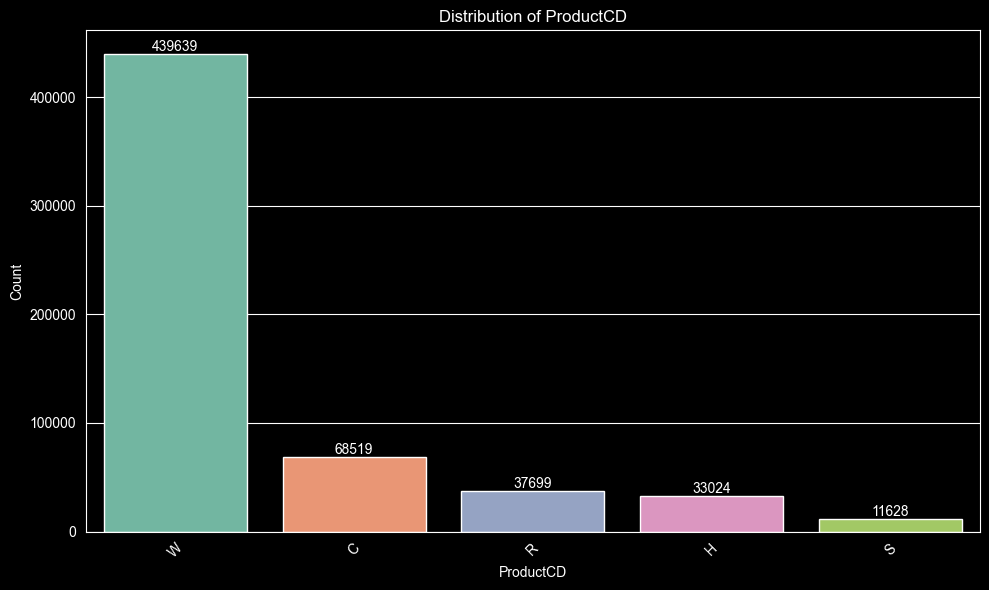

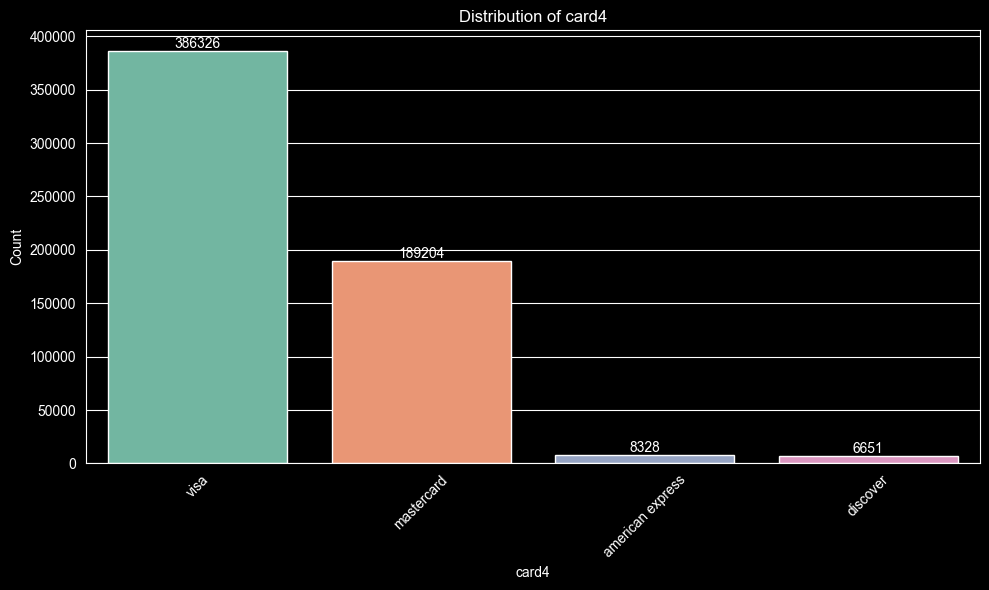

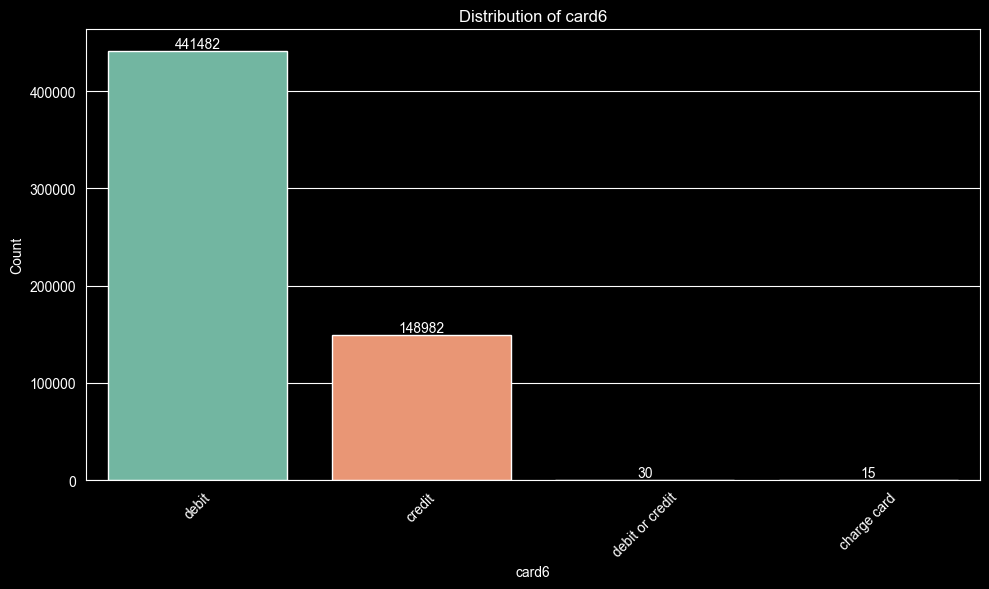

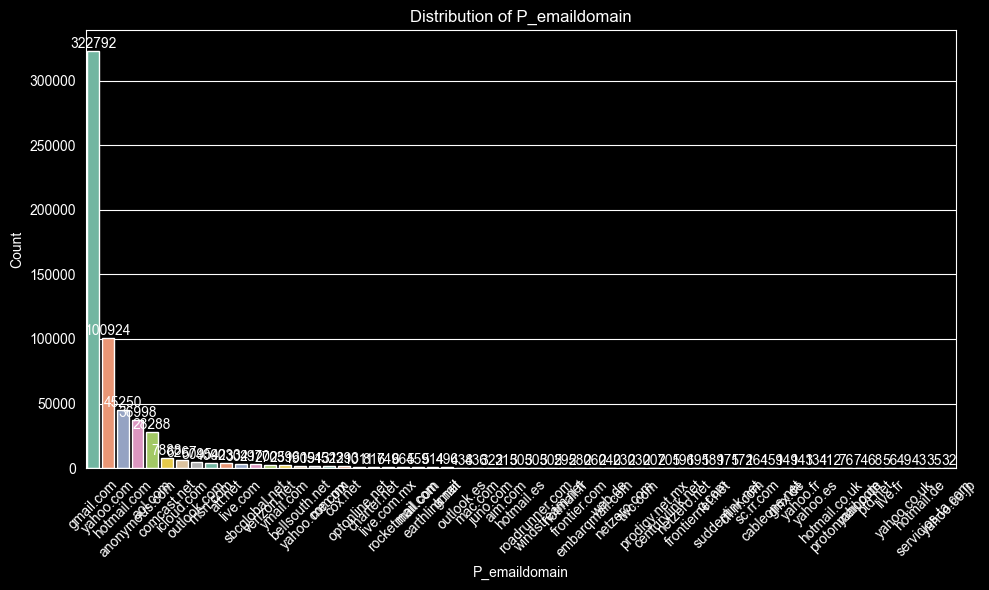

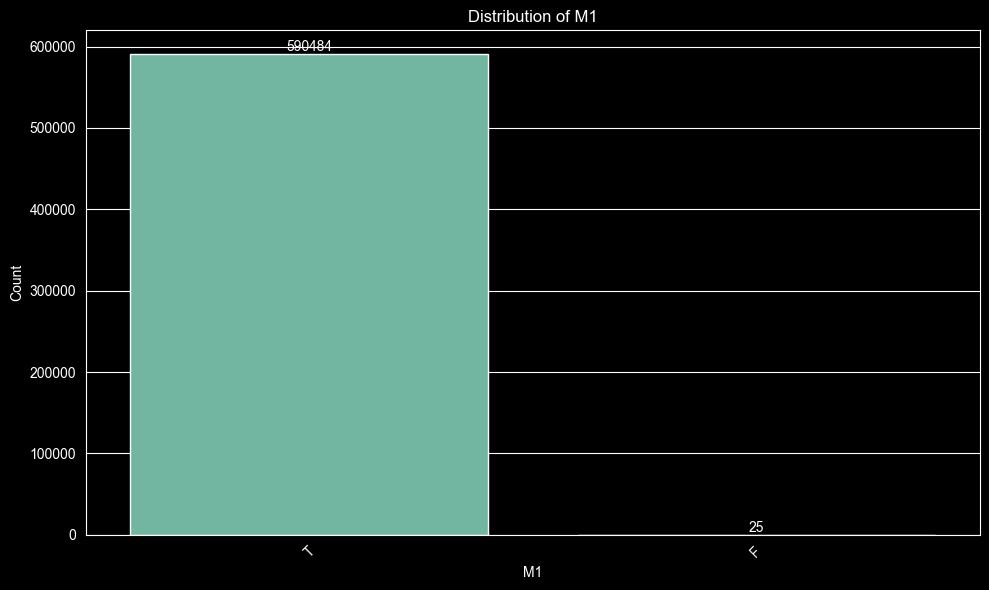

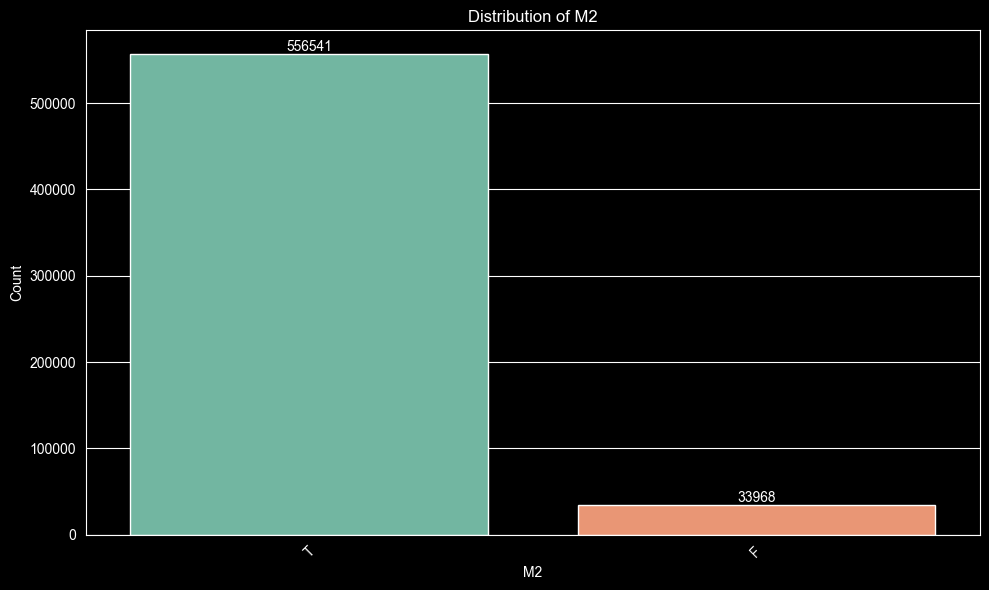

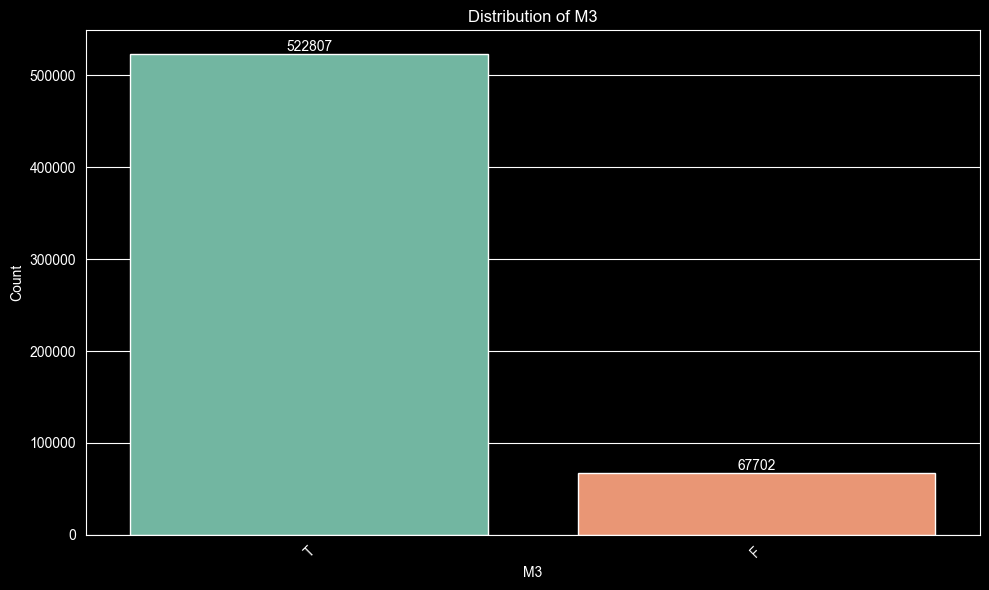

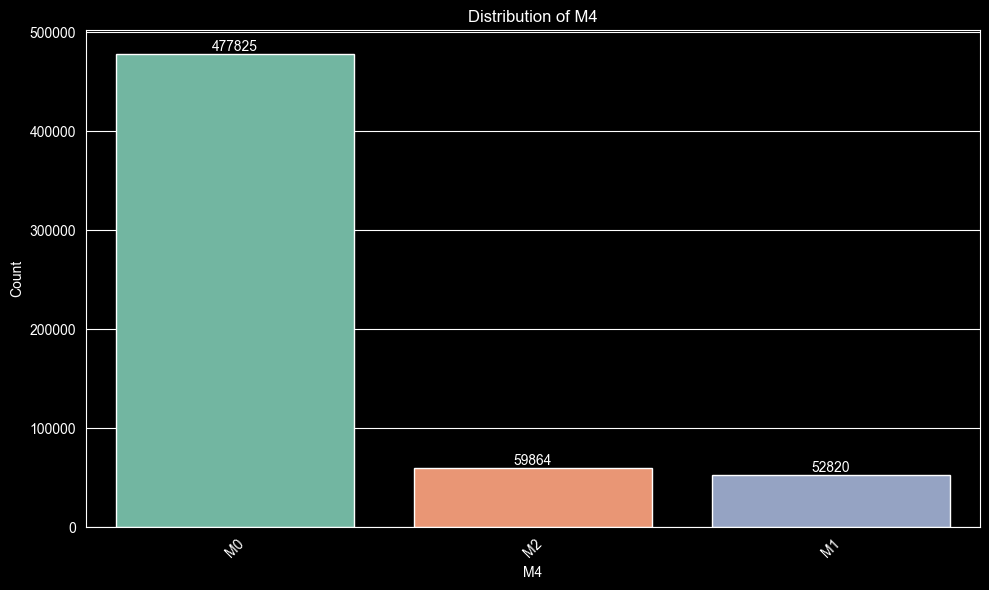

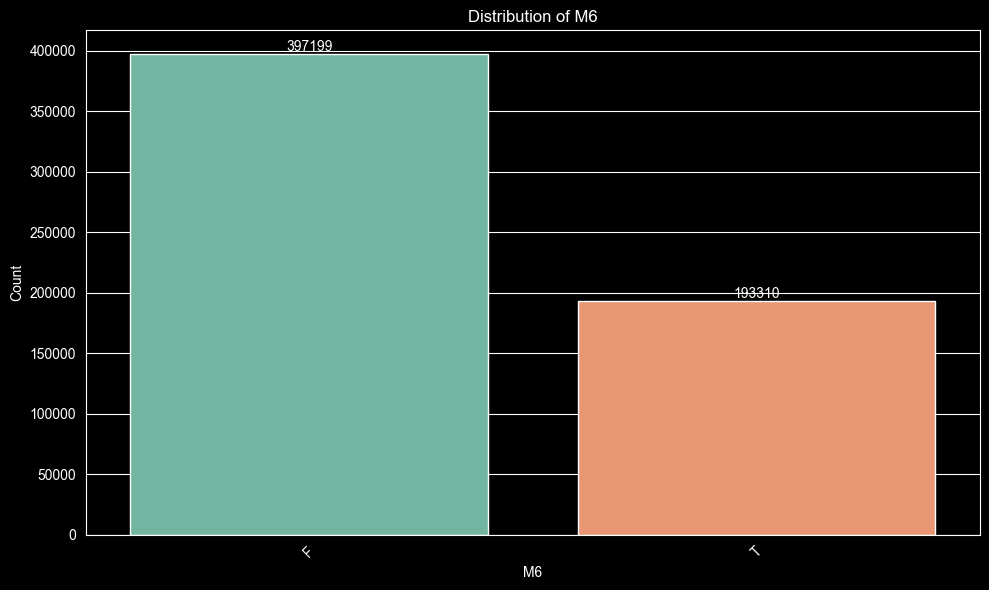

In [10]:
# view each categorical column distribution
for col in categorical_columns:
    plot_categorical_distribution(transaction_data_df, col)


### Note:
Encode categorical variables with high cardinality using **target encoding**, and lowerer (less than 2 values) cardinality using **one-hot encoding**

In [11]:
# get cardinality of categorical columns
categorical_cardinality = get_categorical_value_counts(transaction_data_df, categorical_columns)
print ("Categorical Columns Cardinality:")
print (categorical_cardinality)

Categorical Columns Cardinality:
          column  value_count
0      ProductCD            5
1          card4            4
2          card6            4
3  P_emaildomain           59
4             M1            2
5             M2            2
6             M3            2
7             M4            3
8             M6            2


In [11]:
# export this cardinality information to csv for future reference
export_dataframe_to_csv(categorical_cardinality, data_base_path + "processed/null_value_option_1","unified_transaction_data_option1_categorical_cardinality.csv")

DataFrame successfully exported to: ../data/processed/null_value_option_1\unified_transaction_data_option1_categorical_cardinality.csv


'../data/processed/null_value_option_1\\unified_transaction_data_option1_categorical_cardinality.csv'

In [12]:
# one-hot encode categorical columns with less than 2 unique values
max_cardinality_one_hot = 2
columns_for_one_hot = categorical_cardinality.loc[categorical_cardinality["value_count"] <= max_cardinality_one_hot]["column"].tolist()
print(f"Columns to be one-hot encoded (cardinality <= {max_cardinality_one_hot}):")
print(columns_for_one_hot)

Columns to be one-hot encoded (cardinality <= 2):
['M1', 'M2', 'M3', 'M6']


In [13]:
# one-hot encode selected columns
one_hot_encoded_data = one_hot_encode(transaction_data_df, columns_for_one_hot)

In [14]:
one_hot_encoded_data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,P_emaildomain,C1,C2,...,C10,C11,C12,C13,C14,M4,M1_T,M2_T,M3_T,M6_T
0,0,86400,68.5,W,13926,discover,credit,gmail.com,1.0,1.0,...,0.0,2.0,0.0,1.0,1.0,M2,1.0,1.0,1.0,1.0
1,0,86401,29.0,W,2755,mastercard,credit,gmail.com,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,M0,1.0,1.0,1.0,1.0
2,0,86469,59.0,W,4663,visa,debit,outlook.com,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,M0,1.0,1.0,1.0,0.0
3,0,86499,50.0,W,18132,mastercard,debit,yahoo.com,2.0,5.0,...,0.0,1.0,0.0,25.0,1.0,M0,1.0,1.0,1.0,0.0
4,0,86506,50.0,H,4497,mastercard,credit,gmail.com,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,M0,1.0,1.0,1.0,0.0


### Note:
The remaining categorical columns with high cardinality will be target encoded after splitting the dataset into train and test sets to avoid data leakage

In [15]:
# split dataset into train and test sets
# 60% train, 20% val, 20% test

target_df = one_hot_encoded_data[target_variable]
one_hot_encoded_data = drop_columns(one_hot_encoded_data, [target_variable])


# 20% test first
X_temp, X_test_df, y_temp, y_test_df = train_test_split(
    one_hot_encoded_data,
    target_df,
    test_size=0.2,
    random_state=42,
    stratify=target_df
)

# split remaining 80% into train (60% total) and val (20% total)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
    X_temp,
    y_temp,
    train_size=0.75,  # 0.6 / 0.8
    random_state=42,
    stratify=y_temp
)

# reset indices
for df in [X_train_df, X_val_df, X_test_df, y_train_df, y_val_df, y_test_df]:
    df.reset_index(drop=True, inplace=True)

# show dimensions
dataset_dimension("X Train Set", X_train_df)
dataset_dimension("X Validation Set", X_val_df)
dataset_dimension("X Test Set", X_test_df)
dataset_dimension("y Train Set", y_train_df)
dataset_dimension("y Validation Set", y_val_df)
dataset_dimension("y Test Set", y_test_df)


X Train Set dataset dimension: (354305, 26)
X Validation Set dataset dimension: (118102, 26)
X Test Set dataset dimension: (118102, 26)
y Train Set dataset dimension: (354305,)
y Validation Set dataset dimension: (118102,)
y Test Set dataset dimension: (118102,)


In [16]:
# get remaining categorical columns for target encoding
categorical_cols_for_target_encoding = [col for col in categorical_columns if col not in columns_for_one_hot]
print("Categorical Columns for Target Encoding:")
print(categorical_cols_for_target_encoding)

Categorical Columns for Target Encoding:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M4']


In [17]:
# target encoding for remaining categorical columns
target_encoder = TargetEncoder(cols=categorical_cols_for_target_encoding, smoothing=5)

X_train_encoded_df = target_encoder.fit_transform(X_train_df, y_train_df)
X_test_encoded_df = target_encoder.transform(X_test_df)
X_validation_encoded_df = target_encoder.transform(X_val_df)

In [18]:
dataset_dimension("X Train Encoded Set", X_train_encoded_df)
dataset_dimension("X Test Encoded Set", X_test_encoded_df)
dataset_dimension("X Validation Encoded Set", X_validation_encoded_df)

X Train Encoded Set dataset dimension: (354305, 26)
X Test Encoded Set dataset dimension: (118102, 26)
X Validation Encoded Set dataset dimension: (118102, 26)


In [23]:
# define sub-directory for exports
sub_directory = "null_value_option_1_with_validation_set"

In [42]:
# export target encoder object for future use
fitted_modules_base = "fitted_modules/"
encoder_export_path = fitted_modules_base + sub_directory + "/target_encoder.joblib"
joblib.dump(target_encoder, encoder_export_path)

In [40]:
X_train_encoded_df.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card4,card6,P_emaildomain,C1,C2,C3,...,C10,C11,C12,C13,C14,M4,M1_T,M2_T,M3_T,M6_T
0,2158117,100.000,0.037941,4208,0.034427,0.024210,0.023468,1.0,1.0,0.0,...,1.0,2.0,0.0,4.0,1.0,0.026149,1.0,1.0,1.0,0.0
1,14860409,49.000,0.020385,1939,0.034427,0.024210,0.022062,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.026149,1.0,1.0,1.0,0.0
2,9752392,34.742,0.116490,6751,0.034427,0.024210,0.052421,2.0,4.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.026149,1.0,1.0,1.0,0.0
3,6246433,80.000,0.059463,5680,0.034709,0.066794,0.039616,2.0,2.0,0.0,...,6.0,1.0,0.0,18.0,2.0,0.026149,1.0,1.0,1.0,0.0
4,8359507,53.170,0.116490,15885,0.034427,0.024210,0.093892,1.0,5.0,0.0,...,3.0,2.0,2.0,3.0,1.0,0.026149,1.0,1.0,1.0,0.0


In [43]:
# export preprocessed datasets to csv
export_dir = data_base_path + "processed/" + sub_directory
export_dataframe_to_csv(X_train_encoded_df, export_dir,"unified_transaction_data_option2_x_train.csv")
export_dataframe_to_csv(X_validation_encoded_df, export_dir,"unified_transaction_data_option2_x_validation.csv")
export_dataframe_to_csv(X_test_encoded_df, export_dir,"unified_transaction_data_option2_x_test.csv")
export_dataframe_to_csv(y_train_df, export_dir,"unified_transaction_data_option2_y_train.csv")
export_dataframe_to_csv(y_val_df, export_dir,"unified_transaction_data_option2_y_validation.csv")
export_dataframe_to_csv(y_test_df, export_dir,"unified_transaction_data_option2_y_test.csv")

DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set\unified_transaction_data_option2_x_train.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set\unified_transaction_data_option2_x_validation.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set\unified_transaction_data_option2_x_test.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set\unified_transaction_data_option2_y_train.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set\unified_transaction_data_option2_y_validation.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set\unified_transaction_data_option2_y_test.csv


'data/processed/null_value_option_1_with_validation_set\\unified_transaction_data_option2_y_test.csv'

### Normalization/Standardization

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded_df)
X_validation_scaled = scaler.transform(X_validation_encoded_df)
X_test_scaled = scaler.transform(X_test_encoded_df)

dataset_dimension("X Train Scaled Set", X_train_scaled)
dataset_dimension("X Validation Scaled Set", X_validation_scaled)
dataset_dimension("X Test Scaled Set", X_test_scaled)

X Train Scaled Set dataset dimension: (354305, 26)
X Validation Scaled Set dataset dimension: (118102, 26)
X Test Scaled Set dataset dimension: (118102, 26)


In [45]:
scaler_export_path = fitted_modules_base + sub_directory + "/standard_scaler.joblib"
joblib.dump(scaler, scaler_export_path)

['fitted_modules/null_value_option_1_with_validation_set/standard_scaler.joblib']

In [20]:
X_train_scaled

array([[-1.12736122, -0.14384084,  0.09593716, ...,  0.24582167,
         0.35966116, -0.69693884],
       [ 1.62294599, -0.35328888, -0.4731489 , ...,  0.24582167,
         0.35966116, -0.69693884],
       [ 0.51695536, -0.41184398,  2.64219241, ...,  0.24582167,
         0.35966116, -0.69693884],
       ...,
       [-0.53484841,  0.3282386 , -0.4731489 , ...,  0.24582167,
         0.35966116, -0.69693884],
       [-0.20770514, -0.41283783, -0.4731489 , ...,  0.24582167,
         0.35966116,  1.43484613],
       [-0.92897427,  5.09437241, -0.4731489 , ...,  0.24582167,
         0.35966116, -0.69693884]])

### Class Imbalance Handling
Balancing only the training set using SMOTE

In [47]:
smote = SMOTE(random_state=42, sampling_strategy='auto')

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_df)

print("Original data shape")
dataset_dimension("X Train scaled Set", X_train_scaled)
dataset_dimension("Y Train set", y_train_df)

print("\nBalanced data shape")
dataset_dimension("X Train Balanced Set", X_train_balanced)
dataset_dimension("y Train Balanced Set", y_train_balanced)

Original data shape
X Train scaled Set dataset dimension: (354305, 26)
Y Train set dataset dimension: (354305,)

Balanced data shape
X Train Balanced Set dataset dimension: (683822, 26)
y Train Balanced Set dataset dimension: (683822,)


D:\personal\studies\msc\Reserach\implementations\python\notebooks\globals\data_visualizations.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=values, palette=color_palette, order=value_counts.index)


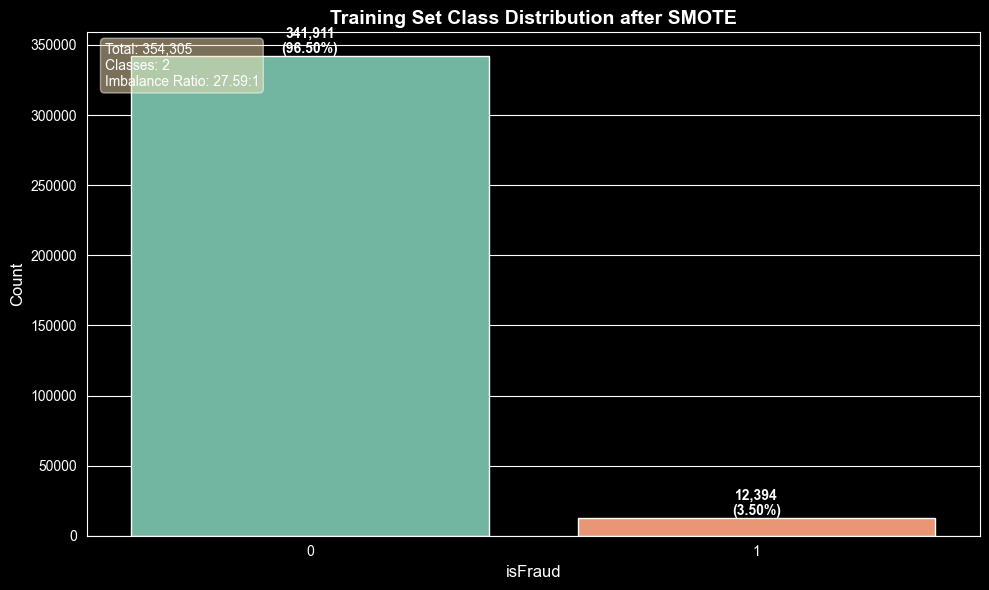

In [21]:
show_class_count_plot(y_train_balanced, target_variable, "Training Set Class Distribution after SMOTE")

In [24]:
# export without balancing for auto encoder model
export_dir = data_base_path + "processed/" + sub_directory + "/scaled_only"
# train set
export_dataframe_to_csv(pd.DataFrame(X_train_scaled), export_dir,"unified_transaction_data_option2_x_train_scaled.csv")
export_dataframe_to_csv(pd.DataFrame(y_train_df), export_dir,"unified_transaction_data_option2_y_train.csv")

# validation set
export_dataframe_to_csv(pd.DataFrame(X_validation_scaled), export_dir,"unified_transaction_data_option2_x_validation_scaled.csv")
export_dataframe_to_csv(y_val_df, export_dir,"unified_transaction_data_option2_y_validation.csv")

# test set
export_dataframe_to_csv(pd.DataFrame(X_test_scaled), export_dir,"unified_transaction_data_option2_x_test_scaled.csv")
export_dataframe_to_csv(y_test_df, export_dir,"unified_transaction_data_option2_y_test.csv")

DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_only\unified_transaction_data_option2_x_train_scaled.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_only\unified_transaction_data_option2_y_train.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_only\unified_transaction_data_option2_x_validation_scaled.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_only\unified_transaction_data_option2_y_validation.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_only\unified_transaction_data_option2_x_test_scaled.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_only\unified_transaction_data_option2_y_test.csv


'data/processed/null_value_option_1_with_validation_set/scaled_only\\unified_transaction_data_option2_y_test.csv'

In [49]:
# export balanced training set to csv
export_dir = data_base_path + "processed/" + sub_directory + "/scaled_and_balanced"

# train set
export_dataframe_to_csv(pd.DataFrame(X_train_balanced), export_dir,"unified_transaction_data_option2_x_train_balanced.csv")
export_dataframe_to_csv(pd.DataFrame(y_train_balanced), export_dir,"unified_transaction_data_option2_y_train_balanced.csv")

# validation set
export_dataframe_to_csv(pd.DataFrame(X_validation_scaled), export_dir,"unified_transaction_data_option2_x_validation_scaled.csv")
export_dataframe_to_csv(y_val_df, export_dir,"unified_transaction_data_option2_y_validation.csv")

# test set
export_dataframe_to_csv(pd.DataFrame(X_test_scaled), export_dir,"unified_transaction_data_option2_x_test_scaled.csv")
export_dataframe_to_csv(y_test_df, export_dir,"unified_transaction_data_option2_y_test.csv")

DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\unified_transaction_data_option2_x_train_balanced.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\unified_transaction_data_option2_y_train_balanced.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\unified_transaction_data_option2_x_validation_scaled.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\unified_transaction_data_option2_y_validation.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\unified_transaction_data_option2_x_test_scaled.csv
DataFrame successfully exported to: data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\unified_transaction_data_option2_y_test.csv


'data/processed/null_value_option_1_with_validation_set/scaled_and_balanced\\unified_transaction_data_option2_y_test.csv'